In [62]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [125]:
# read data
df_sf = pd.read_csv('sf_data.csv', sep=';')
df_district = pd.read_csv('sf_districts.csv', sep=';')

In [126]:
def load_data(df, df_district):
    # import data from csv separated by semicolon
    df = pd.read_csv('sf_data.csv', sep=';')

    df_district = pd.read_csv('sf_districts.csv', sep=';')

    # merge dataframes on id
    df = pd.merge(df, df_district, on='id') # this is a left join that drops na values

    # check for missing values
    print(f'this is how many na values are in the dataframe: {df.isna().sum()}')

    return df



In [127]:
df = load_data(df, df_district)

this is how many na values are in the dataframe: id             0
category       0
description    0
weekday        0
date           0
time           0
resolution     0
longitude      0
latitude       0
label          0
district       0
dtype: int64


In [128]:
def format_data(df):
    # convert all object columns to category
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype('category')

    # make weekday column a datetime object where monday is 0 and sunday is 6
    df['weekday'] = pd.to_datetime(df['date']).dt.dayofweek

    # make date column a datetime object
    df['date'] = pd.to_datetime(df['date']).dt.date

    # make time column a datetime object
    df['time'] = pd.to_datetime(df['time']).dt.time

    # make a new column that is date and time combined
    df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

    # set datetime as index
    df.set_index('datetime')

    return df



In [129]:
# use function to clean data
df = format_data(df)

In [130]:
# print data types for sanity check
print(df.dtypes)

id                      int64
category             category
description          category
weekday                 int64
date                   object
time                   object
resolution           category
longitude             float64
latitude              float64
label                category
district             category
datetime       datetime64[ns]
dtype: object


/var/folders/_c/3l9yllq94xz0c2hc259xh3jc0000gn/T/ipykernel_23678/1119003012.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=90)


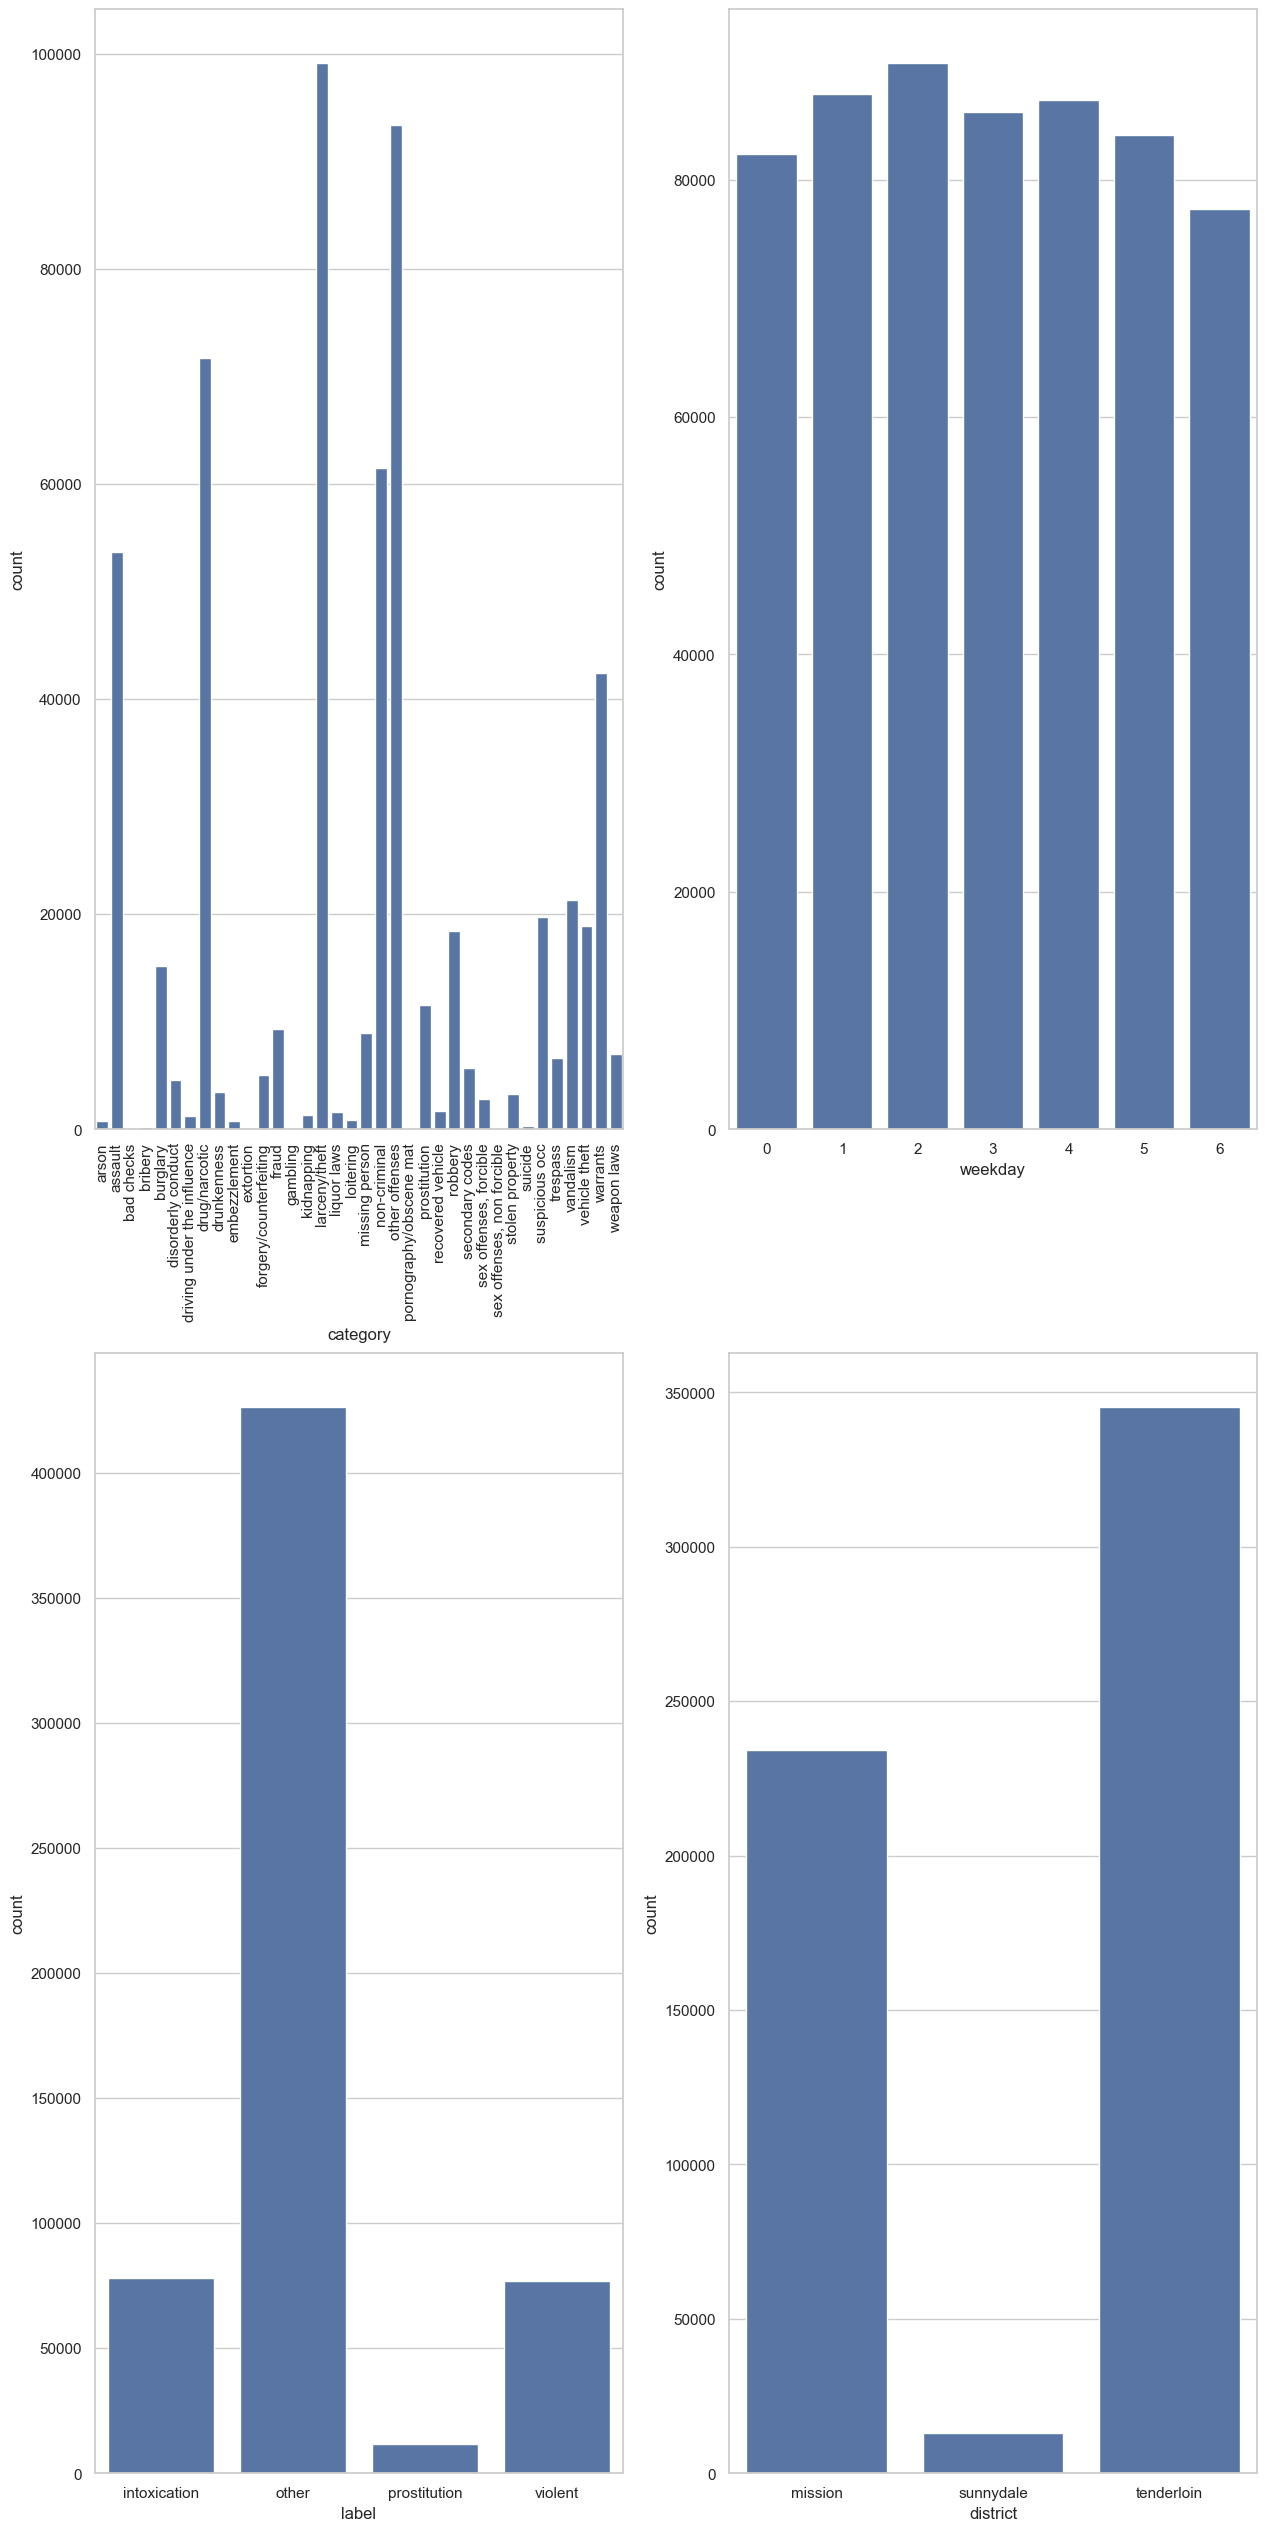

In [132]:
# visualize using bar plots
# put all plots into one plot
fig, ax = plt.subplots(2, 2, figsize=(15, 32))

# plot all the data
# rotate x labels
sns.countplot(x='category', data=df, ax=ax[0, 0])
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=90)
sns.countplot(x='weekday', data=df, ax=ax[0, 1])
sns.countplot(x='label', data=df, ax=ax[1, 0])
sns.countplot(x='district', data=df, ax=ax[1, 1])

plt.show()


<Axes: xlabel='date'>

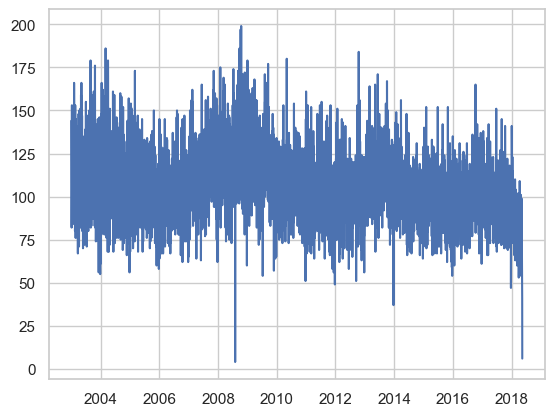

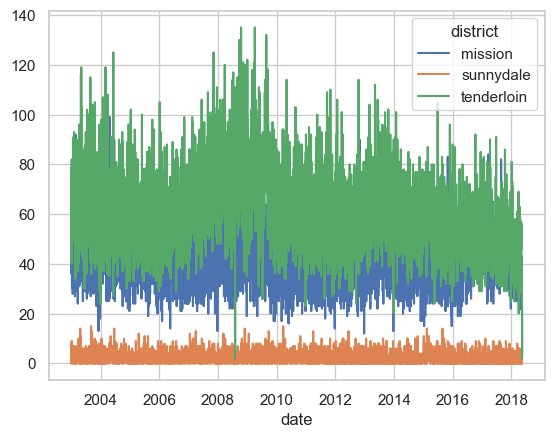

In [135]:
# visualize datetime

# plot the number of crimes
df['date'].value_counts().plot()

# plot number of crimes per day per district
df.groupby(['date', 'district']).size().unstack().plot()

In [94]:
# count unique values in district
print(df['district'].nunique())

3
